In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
!nvidia-smi

Unable to determine the device handle for GPU 0000:01:00.0: GPU is lost.  Reboot the system to recover this GPU




In [3]:
import sys
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm as tqn
%matplotlib inline

sys.path.append('..//..')

import meters as ms
from meters.batch import MeterBatch
# from meter_batch import MeterBatch
from meters.batch.meter_batch import load_func

from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, DenseNet121, VGG19
# from detection_model import NearestDetection, ClassificationModel

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

In [4]:
# pylint: disable=attribute-defined-outside-init
"""Batch class for water meter task"""
import copy
import numpy as np
import tensorflow as tf
from scipy.special import expit
from scipy.misc import imresize
import matplotlib.pyplot as plt
# import sys
# sys.path.append('..//..//meters/')
from meters.dataset import ImagesBatch, action, inbatch_parallel, any_action_failed, DatasetIndex

In [5]:
src_image = 'seen_images/'
src_data = 'new_data.csv'

fileindex = FilesIndex(path=src_image+'*.jpg', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

In [6]:
BATCH_SIZE = 25
NUM_DIGITS = 8
HEIGHT = 32
WIDTH = 16
VERTICALE_SCALE = 2.5
HORIZONTAL_SCALE = 2
NEW_SIZE = (int(VERTICALE_SCALE * HEIGHT), 192, 3)

In [7]:
NEW_SIZE = (112, 288, 3)

In [8]:
def factor_sampler(size, p_square = 0.5):
    if np.random.binomial(1, p_square):
        return np.random.uniform(0.3, 1.7, (size,))
    return np.random.uniform(0.3, 1.7, (size,2))

def shift_sampler(size):
    return np.hstack((np.random.uniform(-60, 60, (size, 1)),\
                      np.random.uniform(-15, 10, (size, 1)),\
                      np.zeros((size, 1))))

def shape_sampler(size, crop_size=1):
    return np.random.randint(20, 50, (size, crop_size, 2))

def color_sampler(size, crop_size=1):
    return np.random.uniform(0, 1, (size, crop_size, 3))

def background_sampler(size, shape=(120, 120, 3), p_solid = 0.5):
    if np.random.binomial(1, p_solid):
        return np.ones((size, 120,120, 3))*color_sampler(size)[:, np.newaxis,...]
    return np.random.uniform(0, 1, (size,) + shape)

def random_origin_sampler(size, max_=3):
    return [['random'] * np.random.randint(0, max_) for _ in range(size)]
channels = np.array((0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)), dtype=object)
def channels_sampler(size):
    return channels[np.random.randint(len(channels), size=size)]

mode_generator=lambda size: np.random.choice(['constant', 'nearest', 'wrap'], size)

In [9]:
load_ppl = (
    Pipeline()
    .load_pil(src=src_image, components='images')
    .load(src=src_data, fmt='csv', components=['coordinates', 'labels'],
                  post=load_func, index_col='file_name')
    .generate_digit_cordinates()
    .enlarge_coordinates()
    .crop_from_bbox(dst='images')
    .update_digit_coordinates()
    .shuffle_digits(p=0.5,
                    src=['images', 'digit_coordinates', 'labels'], 
                    dst=['images', 'digit_coordinates', 'labels'])
    .skip_digits()
    .assign_confidence()
    .normalize_coordinates(image_src='images')
    .one_hot()
    .multiply(multiplier=1/255., preserve_type=False, 
              src='images',
              dst='new_images')
     .salt(size=lambda: np.random.randint(1, 10, 2),
           color=lambda: np.random.uniform(0, 1, 3),
           p_noise=P(R('uniform', 0.005, 0.01)), p=0.1, 
           src='new_images',
           dst='new_images')
     .posterize(colors_number=R('randint',8,254), p=0.5,
               src='new_images',
               dst='new_images')
     .invert(channels=P(R(channels_sampler)), p=0.3,
             src='new_images',
             dst='new_images')
     .multiplicative_noise(noise=lambda size: np.random.uniform(0.9, 1.1,size=size), p=0.9,
                           src='new_images',
                           dst='new_images')
    .additive_noise(noise=lambda size: np.random.normal(0, 0.01,size=size), p=0.9,
                    src='new_images',
                    dst='new_images')
    .gaussian_filter(sigma=P(R('uniform', 0.01, 1)), p=0.9,
                     src='new_images',
                     dst='new_images')
    .hommography_transform(p=0.7,
                     src=['new_images', 'digit_coordinates', 'labels'],
                     dst=['new_images', 'digit_coordinates', 'labels'])
    .resize((112, 288),  order=1, preserve_range=False, mode='symmetric',
                                    src='new_images', dst='new_images')

#     .dump(dst='./augmented_images/', fmt='blosc', mode='a', components='new_images')
#     .dump(dst='./confidence.csv', fmt='csv', mode='a', components='confidence')
#     .dump(dst='./coordinates.csv', fmt='csv', mode='a', components='coordinates')
#     << dset
)
 

In [10]:
def smooth_l1(labels, predictions, mu=0.02, scope=None, num_digits = 8, *args, **kwargs):
    losses = 0
    for digit in range(num_digits):
        error = predictions[:, digit, :] - labels[:, digit, :]
        abs_error = tf.abs(error)
        quadratic = tf.minimum(mu, abs_error)
        losses += quadratic ** 2 / (2 * mu) + abs_error - quadratic
    return tf.reduce_mean(losses)

In [11]:
def conf_mse(targets, predictions):
    predictions = tf.reshape(predictions, tf.shape(targets))

    ct = tf.reshape(targets[:, :, 0], (-1, 1))
    cp = tf.reshape(predictions[:, :, 0], (-1, 1))

    bt = tf.reshape(targets[:, :, 1:], (-1, 4))
    bp = tf.nn.softplus(tf.reshape(predictions[:, :, 1:], (-1, 4)))
    
    cl = tf.losses.sigmoid_cross_entropy(ct, cp)
    w = tf.maximum(ct, tf.sigmoid(cp))
    
    m = tf.losses.mean_squared_error(bt, bp, weights=w)

    return 0.

In [12]:
NEW_SIZE

(112, 288, 3)

In [13]:
placeholders_config = {'images': {'shape': NEW_SIZE,
                                  'name': 'reshaped_images'},
                       'bbox': {'shape': (NUM_DIGITS, 5), 'name': 'targets'},
#                        'coordinates': {'shape': (NUM_DIGITS, 4), 'name': 'targets'},
#                        'confidence': {'shape': (NUM_DIGITS, 1)}
                      }
                       
config={'inputs': placeholders_config,
        'input_block/inputs': 'images',
        'loss': conf_mse,
#         'num_digits': NUM_DIGITS,
#         'output': dict(ops=['labels', 'proba', 'accuracy'])
}


saved_fetches=[V('loss'),
#                V('outputs'),
               B('predicted_bb'),
#                V('mse'),
#                V('ce_loss')
              ]

fetches_list=['loss',
              'NearestDetection/all_predictions',
#               'NearestDetection/mse',
#               'NearestDetection/ce_loss'
             ]

saved_feed_dict={'images': B('new_images'),
#                  'labels': B('labels'),
#                  'coordinates': B('coordinates'),
#                  'confidence': B('confidence'),
#                  'outputs': 
                }
#         'optimizer':  {'name': 'Momentum', 'momentum': 0.5, 'learning_rate': 0.1}}

In [14]:
class MyModel(ResNet18):
    def build_config(self, names=None):
        config = super().build_config(names)
        config['head']['units'] = 5 * NUM_DIGITS
        return config
    
    def head(self, inputs, **kwargs):
        x = super().head(inputs, **kwargs)
        return x

In [15]:
model = MyModel
name = 'MyModel'

In [16]:
train_ppl = (
    (load_ppl << dset.train)
    .init_variable('model', model)
    .init_variable('loss_history', init_on_each_run=list)
    .init_variable('current_loss', init_on_each_run=list)
    .init_variable('p_bbox', None)
#     .init_variable('mse', init_on_each_run=list)
#     .init_variable('ce_loss', init_on_each_run=list)
#     .init_variable('outputs', init_on_each_run=list)
    .init_model('dynamic',
                V('model'),
                name,
                config=config)
    .train_model('MyModel', fetches=['loss', 'predictions'], feed_dict={'images': B('new_images'), 'bbox': B('target')},
                 save_to=[V('current_loss'), V('p_bbox')])
    #.print(V('current_loss'))
    .update_variable('loss_history', V('current_loss'), mode='a')
)


test_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss_history', init_on_each_run=list)
    .init_variable('p_bbox', None)
    .init_variable('current_loss', init_on_each_run=list)
#     .init_variable('mse', init_on_each_run=list)
#     .init_variable('ce_loss', init_on_each_run=list)
#     .init_variable('proba', init_on_each_run=list)
#     .init_variable('target', init_on_each_run=list)
#     .init_variable('accuracy', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model('MyModel', fetches=['loss', 'predictions'], feed_dict={'images': B('new_images'), 'bbox': B('target')},
                 save_to=[V('current_loss'), V('p_bbox')])
     .update_variable('loss_history', V('current_loss'), mode='a')
)

In [17]:
NUM_ITERS = 5

In [18]:
np.expand_dims(np.zeros((2, 8)), axis=2).shape

(2, 8, 1)

In [ ]:
global_acc = []
for i in tqn(range(NUM_ITERS)):
    tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
    te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\Dari\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Dari\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:37, 37.18s/it]

In [19]:
predictions = np.array(test_ppl.get_variable('p_bbox')).reshape((25, 8, 5))

In [20]:
bboxes = predictions[:, :, 1:]

In [21]:
confidence = predictions[:, :, 0]

In [22]:
def draw_stats(all_stats, labels, title, y_label):
    ''' Draw accuracy/iterations plot '''
    colors = ['r', 'g', 'b', 'plum']
    plt.title(title)
    for i, current in enumerate(all_stats):
        smoothed_current = []
        for j in range(10, len(current) - 10):
            smoothed_current.append(np.mean(current[j-10:j+10]))
        plt.plot(smoothed_current, label=labels[i], c=colors[i])
    plt.xlabel('iteration')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()



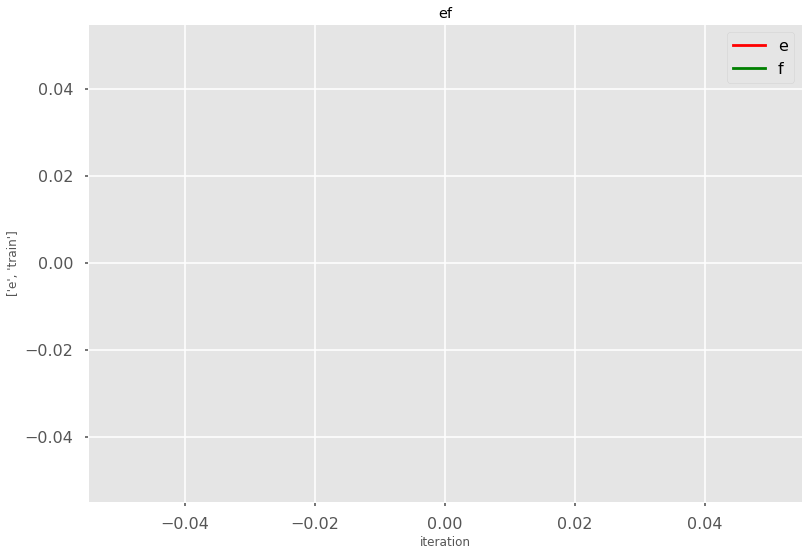

In [23]:
draw_stats([test_ppl.get_variable('loss_history'), train_ppl.get_variable('loss_history')], 'eff', 'ef', ['e', 'train'])

In [24]:
np.array(test_ppl.get_variable('loss')).shape

KeyError: "Variable 'loss' does not exists"

In [ ]:
bboxes

In [ ]:
def unnorm(data):
    data = data.reshape((-1, 4))
    data[:, 0] *= NEW_SIZE[0]
    data[:, 2] *= NEW_SIZE[0]
    data[:, 1] *= NEW_SIZE[1]
    data[:, 3] *= NEW_SIZE[1]
    return data

def plot_results(btch, at_once=True):
    index = np.random.randint(btch.data.images.shape[0])
    img = btch.data.new_images[index]
#     predictions = btch.data.predicted_bb[index].reshape((-1, 5))
    coords = (predictions[index, :, :4])
    print(coords.shape)
    real = unnorm(btch.data.coordinates[index])
    pred_conf = confidence[index, :]
    if at_once:
        fig,ax = plt.subplots(1)
    for i in range(8):
        if not at_once:
            print('pred confidence: ', pred_conf[i], 'real conf: ', btch.data.confidence[index, i, 0])
            fig,ax = plt.subplots(1)
            ax.imshow(img)
            plt.show()
        print(coords[i, :])
        y, x, height, width = coords[i , :]
        pred_rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(pred_rect)

        y, x, height, width = real[i]
        true_rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='g', facecolor='none')
#         ax.add_patch(true_rect)
        

    if at_once:
        ax.imshow(img)
        plt.show()
        print('pred confidence: ', pred_conf, 'real conf: ', btch.data.confidence[index, :, 0])


    

In [ ]:
plot_results(te)